In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

loaded_data = joblib.load("train_data.pkl")

targets, data, ids = loaded_data

# 打印某个人的具体信息

for i in tqdm(range(277)):
    if ids[i] == "03d92c9f6f8a":
        print(f"Target: {targets[i]}")
        print(f"{data[i]}")
        print(type(targets[i]))
        print(type(data[i]))

100%|██████████| 277/277 [00:00<00:00, 34742.45it/s]

Target: [(5928, 13524), (23220, 30276), (40668, 47952), (75756, 82800), (178464, 186564), (196260, 203844), (230820, 241872), (248124, 255060)]
           anglez      enmo      step
0       38.906250  0.080322       0.0
1       29.375000  0.075195       1.0
2       37.218750  0.179077       2.0
3       46.937500  0.092224       3.0
4       60.500000  0.034210       4.0
...           ...       ...       ...
724135 -12.062500  0.038208  724135.0
724136 -15.914062  0.025406  724136.0
724137 -10.859375  0.028107  724137.0
724138  -8.531250  0.027405  724138.0
724139  -9.273438  0.032013  724139.0

[724140 rows x 3 columns]
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [2]:
class CFG:
    window_overlap = 12
    window_size = 12
    train_ratio = 0.80
    batch_size = 32
    input_dim = 2
    embed_dim = 32
    num_classes = 4 
    num_layers = 8
    nhead = 4
    dim_feedforward = 64
    learning_rate = 1e-3
    epochs = 300
    train_record_steps = 140
    test_record_steps = 20
    dropout = 0.4
    num_person = 40
    scheduler_step_size = 20
    scheduler_gamma = 0.8
    fold = 8
    weight_decay = 0.001
    model_dir = "./models"

In [3]:
# 生成放入模型的数据，假设使用30分钟作为一个窗口，那么需要找的为形状（360，2）的矩阵

train_events = pd.read_csv("./train_events.csv")
num_person = len(train_events["series_id"].unique())
print("The number of total persons is:", num_person)

# 用来存储模型的输入与标签
X = []
y = []

for i in tqdm(range(min(num_person, CFG.num_person))):

    df = data[i]
    pair_list = targets[i]
    sleep_id = ids[i]

    # 先提取出开始睡觉和结束睡觉的时间
    onset_steps = []
    wakeup_steps = []
    for j in range(len(pair_list)):
        onset_steps.append(pair_list[j][0])
        wakeup_steps.append(pair_list[j][1])
    # print("length of onset list:", len(onset_steps))
    # print("length of wakeup list:", len(wakeup_steps))
    # print(onset_steps)
    # print(wakeup_steps)

    # 中间没有明确时间点的区间全部都不要
    empty_spaces = []
    events = train_events[train_events["series_id"] == sleep_id]
    last_events = 0
    mark = 0 
    for (idx, row) in events.iterrows():
        if np.isnan(row["step"]):
            mark = 1
        else:
            if row["step"] > last_events and mark == 0:
                last_events = row["step"]
            elif row["step"] > last_events and mark == 1:
                empty_spaces.append((int(last_events + CFG.window_size), int(row["step"] - CFG.window_size)))
                last_events = row["step"]
                mark = 0

    # print(empty_spaces)

    # 为训练数据设置label，如果区间中没有任何事件，标签为0，如果有开始睡觉事件，标签为1，如果有结束睡觉事件，标签为2
    labels = []
    for j in range(0, len(df), CFG.window_overlap):
        start = j
        if j + CFG.window_size >= len(df):
            break
        else:
            end = j + CFG.window_size

        flag_empty = 0
        for k in empty_spaces:
            if (k[0] <= start <= k[1]) or (k[0] <= end <= k[1]):
                flag_empty = 1
                break
            else:
                continue

        flag_sleep = 0
        for k in range(len(onset_steps)):
            if (onset_steps[k] <= start < end <= wakeup_steps[k]):
                flag_sleep = 1
                break
            else:
                continue


        chunk = df.iloc[start:end][["anglez", "enmo"]]
        chunk = chunk.to_numpy()

        if flag_empty == 1:
            label = 4
        elif any(start <= num <= end for num in wakeup_steps):
            label = 3
        elif any(start <= num <= end for num in onset_steps):
            label = 2
        elif flag_sleep == 1:
            label = 1
        else:
            label = 0
        labels.append(label)

        if label != 4:
            X.append(chunk)
            y.append(label)

    element_counts = Counter(labels)

    # for element, count in element_counts.items():
    #     print(f"Element {element} occurs {count} times")

print(len(X), len(y))

The number of total persons is: 277


100%|██████████| 20/20 [05:30<00:00, 16.52s/it]

635999 635999


In [4]:
X_xingzhe = []
y_xingzhe = []
X_shuizhe = []
y_shuizhe = []
X_onset = []
y_onset = []
X_wakeup = []
y_wakeup = []

for i in tqdm(range(len(X))):
    xi = X[i]
    yi = y[i]
    if yi == 0:
        X_xingzhe.append(xi)
        y_xingzhe.append(yi)
    elif yi == 1:
        X_shuizhe.append(xi)
        y_shuizhe.append(yi)
    elif yi == 2:
        X_onset.append(xi)
        y_onset.append(yi)
    elif yi == 3:
        X_wakeup.append(xi)
        y_wakeup.append(yi)

print(len(X_xingzhe), len(X_shuizhe), len(X_onset), len(X_wakeup))

X_xingzhe = X_xingzhe[:max(len(X_onset), len(X_wakeup))]
y_xingzhe = y_xingzhe[:max(len(X_onset), len(X_wakeup))]
X_shuizhe = X_shuizhe[:max(len(X_onset), len(X_wakeup))]
y_shuizhe = y_shuizhe[:max(len(X_onset), len(X_wakeup))]

X = X_xingzhe + X_shuizhe + X_onset + X_wakeup
y = y_xingzhe + y_shuizhe + y_onset + y_wakeup

print(len(X), len(y))

100%|██████████| 635999/635999 [00:00<00:00, 1572219.10it/s]


471615 163143 619 622
2485 2485


In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        inp = self.inputs[index]
        output = self.outputs[index]

        input_tensor = torch.tensor(inp, dtype=torch.float32)
        output_tensor = torch.tensor(output, dtype=torch.long)

        return input_tensor, output_tensor


dataset = MyDataset(X, y)
print(len(dataset))

# train_size = int(CFG.train_ratio * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)
# print(len(train_loader), len(test_loader))

2485


In [9]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        num_classes=3,
        num_layers=8,
        nhead=4,
        dim_feedforward=64,
        dropout=0.4
    ):

        super(TransformerModel, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_dim, 
            out_channels=embed_dim, 
            kernel_size=3, 
            padding=1
        )
        self.embed_layer = nn.Linear(embed_dim, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        self.classification = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x = self.embed_layer(x)
        x = self.layernorm(x)
        x = self.encoder(x.permute(1, 0, 2))
        # print(x.shape)
        x = x[-1]
        x = self.classification(x)
        return x

# 示例
model = TransformerModel(input_dim=2, embed_dim=32)
input_data = torch.rand(3, 360, 2)
output = model(input_data)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(output.shape)

TransformerModel(
  (conv1d): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (embed_layer): Linear(in_features=32, out_features=32, bias=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=3, bias=True)
)
Total 

In [10]:
model = TransformerModel(
    input_dim=CFG.input_dim,
    embed_dim=CFG.embed_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    nhead=CFG.nhead,
    dim_feedforward=CFG.dim_feedforward,
    dropout=CFG.dropout
)

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 52740


In [11]:
train_losses = []
train_step_losses = []
test_losses = []
test_step_losses = []
learning_rates = []

kf = KFold(n_splits=CFG.fold, shuffle=True, random_state=2023)

for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=CFG.batch_size)

    train_model = model.to(device=device)
    train_model.train()

    # init_lr = CFG.learning_rate

    # if fold == 0:
    #     optimizer = torch.optim.Adam(
    #         model.parameters(),
    #         lr=init_lr,
    #         weight_decay=CFG.weight_decay
    #     )
    # else:
    #     # current_learning_rate = optimizer.param_groups[0]["lr"]
    #     # print("current learning rate is:", current_learning_rate)
    #     optimizer = torch.optim.Adam(
    #         model.parameters(),
    #         lr=init_lr / (1.25 ** fold),
    #         weight_decay=CFG.weight_decay
    #     )

    optimizer = torch.optim.Adam(train_model.parameters(), lr=CFG.learning_rate)
    scheduler = StepLR(optimizer, step_size=CFG.scheduler_step_size, gamma=CFG.scheduler_gamma)

    min_loss = 10000.0

    for epoch in range(1, CFG.epochs + 1):
        train_loss = 0.0
        test_loss = 0.0
        train_step_loss = 0.0
        test_step_loss = 0.0


        learning_rate = optimizer.param_groups[0]["lr"]
        learning_rates.append(learning_rate)

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            data = data.to(device)
            target = target.to(device)
            output = train_model(data)

            loss = criterion(output, target)
            train_loss += loss.item()
            train_step_loss += loss.item()

            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % CFG.train_record_steps == 0:
                train_step_loss /= CFG.train_record_steps
                train_step_losses.append(train_step_loss)
                print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.train_record_steps}, Train Loss These Steps: {train_step_loss}")
                train_step_loss = 0.0

        scheduler.step()

        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = train_model(data)

                loss = criterion(output, target)
                test_loss += loss.item()
                test_step_loss += loss.item()

                if (batch_idx + 1) % CFG.test_record_steps == 0:
                    test_step_loss /= CFG.test_record_steps
                    test_step_losses.append(test_step_loss)
                    print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.test_record_steps}, Test Loss These Steps: {test_step_loss}")
                    test_step_loss = 0.0

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if test_loss < min_loss:
            min_loss = test_loss
            torch.save(train_model.state_dict(), f"{CFG.model_dir}/model_{fold + 1}.pth")


        print(f"Fold: {fold + 1}, Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 10/10 [00:00<00:00, 85.69it/s]


Fold: 1, Epoch: 1, Train Loss: 1.3702342685531168, Test Loss: 1.292281413078308


100%|██████████| 10/10 [00:00<00:00, 94.22it/s]


Fold: 1, Epoch: 2, Train Loss: 1.3068119620575624, Test Loss: 1.235479509830475


100%|██████████| 10/10 [00:00<00:00, 89.66it/s]


Fold: 1, Epoch: 3, Train Loss: 1.2589506121242748, Test Loss: 1.2114211738109588


100%|██████████| 10/10 [00:00<00:00, 52.31it/s]


Fold: 1, Epoch: 4, Train Loss: 1.248469343956779, Test Loss: 1.1847685515880584


100%|██████████| 10/10 [00:00<00:00, 95.64it/s]


Fold: 1, Epoch: 5, Train Loss: 1.2064567138166988, Test Loss: 1.1947524309158326


100%|██████████| 10/10 [00:00<00:00, 94.49it/s]


Fold: 1, Epoch: 6, Train Loss: 1.2079567716402166, Test Loss: 1.1445644915103912


100%|██████████| 10/10 [00:00<00:00, 91.59it/s]


Fold: 1, Epoch: 7, Train Loss: 1.186593556228806, Test Loss: 1.1324775338172912


100%|██████████| 10/10 [00:00<00:00, 97.52it/s]


Fold: 1, Epoch: 8, Train Loss: 1.1986934078090332, Test Loss: 1.1185630440711976


100%|██████████| 10/10 [00:00<00:00, 96.25it/s]


Fold: 1, Epoch: 9, Train Loss: 1.1809394456007902, Test Loss: 1.1173203468322754


100%|██████████| 10/10 [00:00<00:00, 100.81it/s]


Fold: 1, Epoch: 10, Train Loss: 1.1712275997680777, Test Loss: 1.132752388715744


100%|██████████| 10/10 [00:00<00:00, 85.28it/s]


Fold: 1, Epoch: 11, Train Loss: 1.1726601623436983, Test Loss: 1.1070920586586


100%|██████████| 10/10 [00:00<00:00, 65.89it/s]


Fold: 1, Epoch: 12, Train Loss: 1.168544558917775, Test Loss: 1.1310479581356048


100%|██████████| 10/10 [00:00<00:00, 112.32it/s]


Fold: 1, Epoch: 13, Train Loss: 1.1759031090666265, Test Loss: 1.1479045391082763


100%|██████████| 10/10 [00:00<00:00, 98.69it/s]


Fold: 1, Epoch: 14, Train Loss: 1.1594183883246254, Test Loss: 1.1435832023620605


100%|██████████| 10/10 [00:00<00:00, 87.69it/s]


Fold: 1, Epoch: 15, Train Loss: 1.1657435709939283, Test Loss: 1.1085828483104705


100%|██████████| 10/10 [00:00<00:00, 66.01it/s]


Fold: 1, Epoch: 16, Train Loss: 1.147389448740903, Test Loss: 1.0929228216409683


100%|██████████| 10/10 [00:00<00:00, 92.06it/s]


Fold: 1, Epoch: 17, Train Loss: 1.1489052325487137, Test Loss: 1.1219267427921296


100%|██████████| 10/10 [00:00<00:00, 97.35it/s]


Fold: 1, Epoch: 18, Train Loss: 1.1526458876974441, Test Loss: 1.0941184312105179


100%|██████████| 10/10 [00:00<00:00, 75.39it/s]


Fold: 1, Epoch: 19, Train Loss: 1.1506778028081446, Test Loss: 1.1183764815330506


100%|██████████| 10/10 [00:00<00:00, 108.99it/s]


Fold: 1, Epoch: 20, Train Loss: 1.144876406473272, Test Loss: 1.1175770521163941


100%|██████████| 10/10 [00:00<00:00, 105.54it/s]


Fold: 1, Epoch: 21, Train Loss: 1.1453374641783096, Test Loss: 1.0946388781070708


100%|██████████| 10/10 [00:00<00:00, 103.37it/s]


Fold: 1, Epoch: 22, Train Loss: 1.142866495777579, Test Loss: 1.1334388971328735


100%|██████████| 10/10 [00:00<00:00, 52.37it/s]


Fold: 1, Epoch: 23, Train Loss: 1.1376586135695963, Test Loss: 1.0914825260639192


100%|██████████| 10/10 [00:00<00:00, 96.98it/s]


Fold: 1, Epoch: 24, Train Loss: 1.1436680415097404, Test Loss: 1.073995155096054


100%|██████████| 10/10 [00:00<00:00, 108.98it/s]


Fold: 1, Epoch: 25, Train Loss: 1.1217950494850384, Test Loss: 1.0986065089702606


100%|██████████| 10/10 [00:00<00:00, 74.92it/s]


Fold: 1, Epoch: 26, Train Loss: 1.1497629416339539, Test Loss: 1.1088379085063935


100%|██████████| 10/10 [00:00<00:00, 108.45it/s]


Fold: 1, Epoch: 27, Train Loss: 1.1362121508401983, Test Loss: 1.0850198984146118


100%|██████████| 10/10 [00:00<00:00, 104.44it/s]


Fold: 1, Epoch: 28, Train Loss: 1.1329145904849558, Test Loss: 1.1166881263256072


100%|██████████| 10/10 [00:00<00:00, 110.27it/s]


Fold: 1, Epoch: 29, Train Loss: 1.1178894656545975, Test Loss: 1.068708485364914


100%|██████████| 10/10 [00:00<00:00, 110.47it/s]


Fold: 1, Epoch: 30, Train Loss: 1.114926938624943, Test Loss: 1.0875829398632049


100%|██████████| 10/10 [00:00<00:00, 113.21it/s]


Fold: 1, Epoch: 31, Train Loss: 1.129833342397914, Test Loss: 1.101360097527504


100%|██████████| 10/10 [00:00<00:00, 107.07it/s]


Fold: 1, Epoch: 32, Train Loss: 1.1134873356889277, Test Loss: 1.0847184836864472


100%|██████████| 10/10 [00:00<00:00, 104.40it/s]


Fold: 1, Epoch: 33, Train Loss: 1.1424463855869629, Test Loss: 1.1098382472991943


100%|██████████| 10/10 [00:00<00:00, 71.42it/s]


Fold: 1, Epoch: 34, Train Loss: 1.1215660370448057, Test Loss: 1.1112658739089967


100%|██████████| 10/10 [00:00<00:00, 101.62it/s]


Fold: 1, Epoch: 35, Train Loss: 1.1146211887107176, Test Loss: 1.0677360743284225


100%|██████████| 10/10 [00:00<00:00, 93.71it/s]


Fold: 1, Epoch: 36, Train Loss: 1.1167352874489391, Test Loss: 1.048838698863983


100%|██████████| 10/10 [00:00<00:00, 103.37it/s]


Fold: 1, Epoch: 37, Train Loss: 1.1086180771098417, Test Loss: 1.0962564915418624


100%|██████████| 10/10 [00:00<00:00, 60.59it/s]


Fold: 1, Epoch: 38, Train Loss: 1.116362971418044, Test Loss: 1.05913607776165


100%|██████████| 10/10 [00:00<00:00, 112.66it/s]


Fold: 1, Epoch: 39, Train Loss: 1.1002198633025675, Test Loss: 1.076867401599884


100%|██████████| 10/10 [00:00<00:00, 103.54it/s]


Fold: 1, Epoch: 40, Train Loss: 1.1043772495844786, Test Loss: 1.0501207292079926


100%|██████████| 10/10 [00:00<00:00, 98.30it/s]


Fold: 1, Epoch: 41, Train Loss: 1.0886535995146807, Test Loss: 1.0830594658851624


100%|██████████| 10/10 [00:00<00:00, 105.94it/s]


Fold: 1, Epoch: 42, Train Loss: 1.103739305454142, Test Loss: 1.0646805822849275


100%|██████████| 10/10 [00:00<00:00, 102.31it/s]


Fold: 1, Epoch: 43, Train Loss: 1.1093166847439373, Test Loss: 1.1014631390571594


100%|██████████| 10/10 [00:00<00:00, 103.35it/s]


Fold: 1, Epoch: 44, Train Loss: 1.1129640060312607, Test Loss: 1.0682495206594467


100%|██████████| 10/10 [00:00<00:00, 69.95it/s]


Fold: 1, Epoch: 45, Train Loss: 1.0986536338048822, Test Loss: 1.077071303129196


100%|██████████| 10/10 [00:00<00:00, 99.40it/s]


Fold: 1, Epoch: 46, Train Loss: 1.099528537953601, Test Loss: 1.1165137946605683


100%|██████████| 10/10 [00:00<00:00, 111.30it/s]


Fold: 1, Epoch: 47, Train Loss: 1.1214783139088575, Test Loss: 1.0958052933216096


100%|██████████| 10/10 [00:00<00:00, 108.38it/s]


Fold: 1, Epoch: 48, Train Loss: 1.0876647374209236, Test Loss: 1.0786615639925003


100%|██████████| 10/10 [00:00<00:00, 103.87it/s]


Fold: 1, Epoch: 49, Train Loss: 1.091314278104726, Test Loss: 1.0635499566793443


100%|██████████| 10/10 [00:00<00:00, 102.31it/s]


Fold: 1, Epoch: 50, Train Loss: 1.0889029537930208, Test Loss: 1.0611437827348709


100%|██████████| 10/10 [00:00<00:00, 100.27it/s]


Fold: 1, Epoch: 51, Train Loss: 1.0899525959702099, Test Loss: 1.0770853638648987


100%|██████████| 10/10 [00:00<00:00, 97.65it/s]


Fold: 1, Epoch: 52, Train Loss: 1.0895414212170769, Test Loss: 1.0754023551940919


100%|██████████| 10/10 [00:00<00:00, 103.49it/s]


Fold: 1, Epoch: 53, Train Loss: 1.0791264825007494, Test Loss: 1.0871631324291229


100%|██████████| 10/10 [00:00<00:00, 110.13it/s]


Fold: 1, Epoch: 54, Train Loss: 1.0874060050529593, Test Loss: 1.0956878304481505


100%|██████████| 10/10 [00:00<00:00, 73.06it/s]


Fold: 1, Epoch: 55, Train Loss: 1.08666091280825, Test Loss: 1.071568250656128


100%|██████████| 10/10 [00:00<00:00, 107.71it/s]


Fold: 1, Epoch: 56, Train Loss: 1.0885713608825909, Test Loss: 1.0980446279048919


100%|██████████| 10/10 [00:00<00:00, 103.72it/s]


Fold: 1, Epoch: 57, Train Loss: 1.0827566192430609, Test Loss: 1.028461292386055


100%|██████████| 10/10 [00:00<00:00, 95.62it/s]


Fold: 1, Epoch: 58, Train Loss: 1.08297779016635, Test Loss: 1.047278481721878


100%|██████████| 10/10 [00:00<00:00, 109.44it/s]


Fold: 1, Epoch: 59, Train Loss: 1.07087259257541, Test Loss: 1.068374228477478


100%|██████████| 10/10 [00:00<00:00, 108.99it/s]


Fold: 1, Epoch: 60, Train Loss: 1.0768889215062647, Test Loss: 1.0448690593242644


100%|██████████| 10/10 [00:00<00:00, 71.11it/s]


Fold: 1, Epoch: 61, Train Loss: 1.0696810703067219, Test Loss: 1.0509938925504685


100%|██████████| 10/10 [00:00<00:00, 87.18it/s]


Fold: 1, Epoch: 62, Train Loss: 1.0667652154670042, Test Loss: 1.057226949930191


100%|██████████| 10/10 [00:00<00:00, 103.37it/s]


Fold: 1, Epoch: 63, Train Loss: 1.072774019311456, Test Loss: 1.073599988222122


100%|██████████| 10/10 [00:00<00:00, 101.42it/s]


Fold: 1, Epoch: 64, Train Loss: 1.0528778346145855, Test Loss: 1.0637971818447114


100%|██████████| 10/10 [00:00<00:00, 108.62it/s]


Fold: 1, Epoch: 65, Train Loss: 1.0766412352814394, Test Loss: 1.0704858601093292


100%|██████████| 10/10 [00:00<00:00, 70.54it/s]


Fold: 1, Epoch: 66, Train Loss: 1.0651650157044916, Test Loss: 1.071251356601715


100%|██████████| 10/10 [00:00<00:00, 102.45it/s]


Fold: 1, Epoch: 67, Train Loss: 1.0764962969457401, Test Loss: 1.054698285460472


100%|██████████| 10/10 [00:00<00:00, 106.97it/s]


Fold: 1, Epoch: 68, Train Loss: 1.0716204923741959, Test Loss: 1.072331964969635


100%|██████████| 10/10 [00:00<00:00, 104.42it/s]


Fold: 1, Epoch: 69, Train Loss: 1.0597313186701607, Test Loss: 1.051033478975296


100%|██████████| 10/10 [00:00<00:00, 101.96it/s]


Fold: 1, Epoch: 70, Train Loss: 1.0656037540996777, Test Loss: 1.0557669758796693


100%|██████████| 10/10 [00:00<00:00, 93.94it/s]


Fold: 1, Epoch: 71, Train Loss: 1.0583894936477436, Test Loss: 1.0562995493412017


100%|██████████| 10/10 [00:00<00:00, 79.90it/s]


Fold: 1, Epoch: 72, Train Loss: 1.0651355964296005, Test Loss: 1.0270053029060364


100%|██████████| 10/10 [00:00<00:00, 88.47it/s]


Fold: 1, Epoch: 73, Train Loss: 1.0629271172425325, Test Loss: 1.0555703699588777


100%|██████████| 10/10 [00:00<00:00, 91.15it/s]


Fold: 1, Epoch: 74, Train Loss: 1.0628601733375997, Test Loss: 1.0529277503490448


100%|██████████| 10/10 [00:00<00:00, 110.94it/s]


Fold: 1, Epoch: 75, Train Loss: 1.0669903693830265, Test Loss: 1.0755079507827758


100%|██████████| 10/10 [00:00<00:00, 108.99it/s]


Fold: 1, Epoch: 76, Train Loss: 1.0625249164945938, Test Loss: 1.058312502503395


100%|██████████| 10/10 [00:00<00:00, 103.14it/s]


Fold: 1, Epoch: 77, Train Loss: 1.058132173383937, Test Loss: 1.0278154760599136


100%|██████████| 10/10 [00:00<00:00, 95.77it/s]


Fold: 1, Epoch: 78, Train Loss: 1.0438088064684587, Test Loss: 1.0569449961185455


100%|██████████| 10/10 [00:00<00:00, 96.48it/s]


Fold: 1, Epoch: 79, Train Loss: 1.0572633638101465, Test Loss: 1.0543632626533508


100%|██████████| 10/10 [00:00<00:00, 75.94it/s]


Fold: 1, Epoch: 80, Train Loss: 1.0525839828393038, Test Loss: 1.060843712091446


100%|██████████| 10/10 [00:00<00:00, 81.75it/s]


Fold: 1, Epoch: 81, Train Loss: 1.054114051601466, Test Loss: 1.0438824236392974


100%|██████████| 10/10 [00:00<00:00, 100.26it/s]


Fold: 1, Epoch: 82, Train Loss: 1.0500833830412697, Test Loss: 1.0591430127620698


100%|██████████| 10/10 [00:00<00:00, 97.72it/s]


Fold: 1, Epoch: 83, Train Loss: 1.041427723625127, Test Loss: 1.0396408647298814


100%|██████████| 10/10 [00:00<00:00, 68.65it/s]


Fold: 1, Epoch: 84, Train Loss: 1.03998100669945, Test Loss: 1.0351338744163514


100%|██████████| 10/10 [00:00<00:00, 103.47it/s]


Fold: 1, Epoch: 85, Train Loss: 1.041232043329407, Test Loss: 1.0539828836917877


100%|██████████| 10/10 [00:00<00:00, 100.27it/s]


Fold: 1, Epoch: 86, Train Loss: 1.0400060441564112, Test Loss: 1.0392900854349136


100%|██████████| 10/10 [00:00<00:00, 96.39it/s]


Fold: 1, Epoch: 87, Train Loss: 1.0426025837659836, Test Loss: 1.0354654729366302


100%|██████████| 10/10 [00:00<00:00, 109.07it/s]


Fold: 1, Epoch: 88, Train Loss: 1.03875952696099, Test Loss: 1.0521026343107223


100%|██████████| 10/10 [00:00<00:00, 68.56it/s]


Fold: 1, Epoch: 89, Train Loss: 1.0497142953031204, Test Loss: 1.051265001296997


100%|██████████| 10/10 [00:00<00:00, 100.74it/s]


Fold: 1, Epoch: 90, Train Loss: 1.0469457813922096, Test Loss: 1.058515578508377


100%|██████████| 10/10 [00:00<00:00, 107.82it/s]


Fold: 1, Epoch: 91, Train Loss: 1.0423490887179094, Test Loss: 1.0578760623931884


100%|██████████| 10/10 [00:00<00:00, 102.75it/s]


Fold: 1, Epoch: 92, Train Loss: 1.0400439851424272, Test Loss: 1.0471522033214569


100%|██████████| 10/10 [00:00<00:00, 104.44it/s]


Fold: 1, Epoch: 93, Train Loss: 1.0394808728905285, Test Loss: 1.0309253662824631


100%|██████████| 10/10 [00:00<00:00, 102.30it/s]


Fold: 1, Epoch: 94, Train Loss: 1.0298292540452059, Test Loss: 1.0092250734567643


100%|██████████| 10/10 [00:00<00:00, 103.37it/s]


Fold: 1, Epoch: 95, Train Loss: 1.038117981132339, Test Loss: 1.082711511850357


100%|██████████| 10/10 [00:00<00:00, 105.55it/s]


Fold: 1, Epoch: 96, Train Loss: 1.0336899196400362, Test Loss: 1.0327819287776947


100%|██████████| 10/10 [00:00<00:00, 100.53it/s]


Fold: 1, Epoch: 97, Train Loss: 1.0429905162138098, Test Loss: 1.0441938281059264


100%|██████████| 10/10 [00:00<00:00, 98.86it/s]


Fold: 1, Epoch: 98, Train Loss: 1.0216314818929224, Test Loss: 1.041487890481949


100%|██████████| 10/10 [00:00<00:00, 107.73it/s]


Fold: 1, Epoch: 99, Train Loss: 1.0460384786128998, Test Loss: 1.0687431335449218


100%|██████████| 10/10 [00:00<00:00, 104.56it/s]


Fold: 1, Epoch: 100, Train Loss: 1.0278548905078102, Test Loss: 1.0346290171146393


100%|██████████| 10/10 [00:00<00:00, 105.09it/s]


Fold: 1, Epoch: 101, Train Loss: 1.0271262061946533, Test Loss: 1.042057079076767


100%|██████████| 10/10 [00:00<00:00, 106.67it/s]


Fold: 1, Epoch: 102, Train Loss: 1.026007882812444, Test Loss: 1.0361715376377105


100%|██████████| 10/10 [00:00<00:00, 96.41it/s]


Fold: 1, Epoch: 103, Train Loss: 1.015410123502507, Test Loss: 1.0115120649337768


100%|██████████| 10/10 [00:00<00:00, 105.74it/s]


Fold: 1, Epoch: 104, Train Loss: 1.0208113175981186, Test Loss: 1.074994158744812


100%|██████████| 10/10 [00:00<00:00, 107.96it/s]


Fold: 1, Epoch: 105, Train Loss: 1.0174035044277416, Test Loss: 1.0535255908966064


100%|██████████| 10/10 [00:00<00:00, 104.11it/s]


Fold: 1, Epoch: 106, Train Loss: 1.016355714377235, Test Loss: 1.0304821699857711


100%|██████████| 10/10 [00:00<00:00, 99.27it/s]


Fold: 1, Epoch: 107, Train Loss: 1.025297165793531, Test Loss: 1.0128581643104553


100%|██████████| 10/10 [00:00<00:00, 103.78it/s]


Fold: 1, Epoch: 108, Train Loss: 1.0187720367137123, Test Loss: 1.0421028137207031


100%|██████████| 10/10 [00:00<00:00, 105.77it/s]


Fold: 1, Epoch: 109, Train Loss: 1.0319225016762228, Test Loss: 1.0399104416370393


100%|██████████| 10/10 [00:00<00:00, 105.54it/s]


Fold: 1, Epoch: 110, Train Loss: 1.0054275305832134, Test Loss: 1.019916221499443


100%|██████████| 10/10 [00:00<00:00, 107.56it/s]


Fold: 1, Epoch: 111, Train Loss: 1.0263925519059687, Test Loss: 1.0327861517667771


100%|██████████| 10/10 [00:00<00:00, 116.78it/s]


Fold: 1, Epoch: 112, Train Loss: 1.0110640017425312, Test Loss: 1.0237820893526077


100%|██████████| 10/10 [00:00<00:00, 114.32it/s]


Fold: 1, Epoch: 113, Train Loss: 1.0056564965668846, Test Loss: 1.0246571868658065


100%|██████████| 10/10 [00:00<00:00, 100.50it/s]


Fold: 1, Epoch: 114, Train Loss: 1.0054296334000195, Test Loss: 1.0167797774076461


100%|██████████| 10/10 [00:00<00:00, 68.19it/s]


Fold: 1, Epoch: 115, Train Loss: 1.0057035596931683, Test Loss: 1.054013466835022


100%|██████████| 10/10 [00:00<00:00, 109.15it/s]


Fold: 1, Epoch: 116, Train Loss: 1.0119291333591236, Test Loss: 1.039635956287384


100%|██████████| 10/10 [00:00<00:00, 98.29it/s]


Fold: 1, Epoch: 117, Train Loss: 1.0021719766013764, Test Loss: 1.0000049620866776


100%|██████████| 10/10 [00:00<00:00, 99.37it/s]


Fold: 1, Epoch: 118, Train Loss: 1.0216333953773273, Test Loss: 1.0280041217803955


100%|██████████| 10/10 [00:00<00:00, 95.67it/s]


Fold: 1, Epoch: 119, Train Loss: 1.0073314431835623, Test Loss: 1.0287504374980927


100%|██████████| 10/10 [00:00<00:00, 108.40it/s]


Fold: 1, Epoch: 120, Train Loss: 1.005317013053333, Test Loss: 1.0015785604715348


100%|██████████| 10/10 [00:00<00:00, 100.26it/s]


Fold: 1, Epoch: 121, Train Loss: 0.9896875444580527, Test Loss: 1.0217035949230193


100%|██████████| 10/10 [00:00<00:00, 71.11it/s]


Fold: 1, Epoch: 122, Train Loss: 1.014984698856578, Test Loss: 1.0648433804512023


100%|██████████| 10/10 [00:00<00:00, 105.72it/s]


Fold: 1, Epoch: 123, Train Loss: 0.9998358190059662, Test Loss: 0.9932184934616088


100%|██████████| 10/10 [00:00<00:00, 94.12it/s]


Fold: 1, Epoch: 124, Train Loss: 1.0044305000235052, Test Loss: 1.0266824394464493


100%|██████████| 10/10 [00:00<00:00, 107.81it/s]


Fold: 1, Epoch: 125, Train Loss: 1.0092992966665941, Test Loss: 1.010212966799736


100%|██████████| 10/10 [00:00<00:00, 100.26it/s]


Fold: 1, Epoch: 126, Train Loss: 1.0034228984047384, Test Loss: 1.0244695484638213


100%|██████████| 10/10 [00:00<00:00, 101.34it/s]


Fold: 1, Epoch: 127, Train Loss: 0.9944096856257495, Test Loss: 1.0163432121276856


100%|██████████| 10/10 [00:00<00:00, 70.39it/s]


Fold: 1, Epoch: 128, Train Loss: 0.9971747433438021, Test Loss: 0.9864060699939727


100%|██████████| 10/10 [00:00<00:00, 100.27it/s]


Fold: 1, Epoch: 129, Train Loss: 0.9980338908293668, Test Loss: 1.0033727526664733


100%|██████████| 10/10 [00:00<00:00, 102.36it/s]


Fold: 1, Epoch: 130, Train Loss: 1.0019478482358597, Test Loss: 1.012849110364914


100%|██████████| 10/10 [00:00<00:00, 104.03it/s]


Fold: 1, Epoch: 131, Train Loss: 1.0019764093791736, Test Loss: 1.0286440670490264


100%|██████████| 10/10 [00:00<00:00, 108.02it/s]


Fold: 1, Epoch: 132, Train Loss: 0.9851586897583569, Test Loss: 0.9769266068935394


100%|██████████| 10/10 [00:00<00:00, 100.57it/s]


Fold: 1, Epoch: 133, Train Loss: 0.9960153935586705, Test Loss: 1.0716621935367585


100%|██████████| 10/10 [00:00<00:00, 102.32it/s]


Fold: 1, Epoch: 134, Train Loss: 0.9940132393556482, Test Loss: 1.07829207777977


100%|██████████| 10/10 [00:00<00:00, 110.66it/s]


Fold: 1, Epoch: 135, Train Loss: 0.9862311876872006, Test Loss: 1.0245343804359437


100%|██████████| 10/10 [00:00<00:00, 100.26it/s]


Fold: 1, Epoch: 136, Train Loss: 0.9867497007636463, Test Loss: 1.037697547674179


100%|██████████| 10/10 [00:00<00:00, 104.38it/s]


Fold: 1, Epoch: 137, Train Loss: 0.991167367381208, Test Loss: 0.9974444299936295


100%|██████████| 10/10 [00:00<00:00, 73.44it/s]


Fold: 1, Epoch: 138, Train Loss: 0.9873387094806222, Test Loss: 1.0163573503494263


100%|██████████| 10/10 [00:00<00:00, 104.24it/s]


Fold: 1, Epoch: 139, Train Loss: 0.9883837244089912, Test Loss: 0.9769580751657486


100%|██████████| 10/10 [00:00<00:00, 103.39it/s]


Fold: 1, Epoch: 140, Train Loss: 0.997981962912223, Test Loss: 1.0463796317577363


100%|██████████| 10/10 [00:00<00:00, 101.66it/s]


Fold: 1, Epoch: 141, Train Loss: 0.9959593152298647, Test Loss: 0.9991777509450912


100%|██████████| 10/10 [00:00<00:00, 108.51it/s]


Fold: 1, Epoch: 142, Train Loss: 1.0014365175191093, Test Loss: 1.0117059022188186


100%|██████████| 10/10 [00:00<00:00, 107.81it/s]


Fold: 1, Epoch: 143, Train Loss: 0.9828764428110683, Test Loss: 1.008803778886795


100%|██████████| 10/10 [00:00<00:00, 102.31it/s]


Fold: 1, Epoch: 144, Train Loss: 0.9818843962515101, Test Loss: 1.0180253982543945


100%|██████████| 10/10 [00:00<00:00, 104.39it/s]


Fold: 1, Epoch: 145, Train Loss: 0.9685898817637387, Test Loss: 0.994588041305542


100%|██████████| 10/10 [00:00<00:00, 110.35it/s]


Fold: 1, Epoch: 146, Train Loss: 0.984245182836757, Test Loss: 1.0099625051021577


100%|██████████| 10/10 [00:00<00:00, 109.46it/s]


Fold: 1, Epoch: 147, Train Loss: 0.9905736034407335, Test Loss: 0.9966246277093888


100%|██████████| 10/10 [00:00<00:00, 105.71it/s]


Fold: 1, Epoch: 148, Train Loss: 0.9872867079342112, Test Loss: 1.0139176666736602


100%|██████████| 10/10 [00:00<00:00, 67.37it/s]


Fold: 1, Epoch: 149, Train Loss: 0.9845676430884529, Test Loss: 1.0113194018602372


100%|██████████| 10/10 [00:00<00:00, 110.22it/s]


Fold: 1, Epoch: 150, Train Loss: 0.9820673912763596, Test Loss: 1.0453467220067978


100%|██████████| 10/10 [00:00<00:00, 95.49it/s]


Fold: 1, Epoch: 151, Train Loss: 0.9729679647613975, Test Loss: 1.0075649917125702


100%|██████████| 10/10 [00:00<00:00, 105.54it/s]


Fold: 1, Epoch: 152, Train Loss: 0.9807369419757057, Test Loss: 0.977471598982811


100%|██████████| 10/10 [00:00<00:00, 103.55it/s]


Fold: 1, Epoch: 153, Train Loss: 1.0028134672080768, Test Loss: 0.9989241749048233


100%|██████████| 10/10 [00:00<00:00, 100.76it/s]


Fold: 1, Epoch: 154, Train Loss: 0.9785940664656022, Test Loss: 1.0247039943933487


100%|██████████| 10/10 [00:00<00:00, 96.41it/s]


Fold: 1, Epoch: 155, Train Loss: 0.9851149250479305, Test Loss: 1.0160775065422059


100%|██████████| 10/10 [00:00<00:00, 100.78it/s]


Fold: 1, Epoch: 156, Train Loss: 0.9834689988809473, Test Loss: 1.0203680008649827


100%|██████████| 10/10 [00:00<00:00, 92.74it/s]


Fold: 1, Epoch: 157, Train Loss: 0.9804244374527651, Test Loss: 0.9858364880084991


100%|██████████| 10/10 [00:00<00:00, 98.30it/s]


Fold: 1, Epoch: 158, Train Loss: 0.979570935754215, Test Loss: 1.0290713727474212


100%|██████████| 10/10 [00:00<00:00, 103.90it/s]


Fold: 1, Epoch: 159, Train Loss: 0.9763311770032433, Test Loss: 1.002525970339775


100%|██████████| 10/10 [00:00<00:00, 66.62it/s]


Fold: 1, Epoch: 160, Train Loss: 0.9697000454453861, Test Loss: 1.0181337237358092


100%|██████████| 10/10 [00:00<00:00, 104.39it/s]


Fold: 1, Epoch: 161, Train Loss: 0.9793904835686964, Test Loss: 1.0550436317920684


100%|██████████| 10/10 [00:00<00:00, 97.49it/s]


Fold: 1, Epoch: 162, Train Loss: 0.97100189065232, Test Loss: 1.0035136044025421


100%|██████████| 10/10 [00:00<00:00, 98.11it/s]


Fold: 1, Epoch: 163, Train Loss: 0.9695284524384666, Test Loss: 1.0254267781972886


100%|██████████| 10/10 [00:00<00:00, 100.92it/s]


Fold: 1, Epoch: 164, Train Loss: 0.9600623153588351, Test Loss: 1.015671843290329


100%|██████████| 10/10 [00:00<00:00, 100.81it/s]


Fold: 1, Epoch: 165, Train Loss: 0.9659521378138486, Test Loss: 0.9867948293685913


100%|██████████| 10/10 [00:00<00:00, 66.90it/s]


Fold: 1, Epoch: 166, Train Loss: 0.9667223130955416, Test Loss: 0.9952269464731216


100%|██████████| 10/10 [00:00<00:00, 105.54it/s]


Fold: 1, Epoch: 167, Train Loss: 0.9675726066617405, Test Loss: 0.9877500027418137


100%|██████████| 10/10 [00:00<00:00, 101.61it/s]


Fold: 1, Epoch: 168, Train Loss: 0.9589730168090147, Test Loss: 0.9843886822462082


100%|██████████| 10/10 [00:00<00:00, 101.04it/s]


Fold: 1, Epoch: 169, Train Loss: 0.9579624121679979, Test Loss: 1.0052519500255586


100%|██████████| 10/10 [00:00<00:00, 96.27it/s]


Fold: 1, Epoch: 170, Train Loss: 0.971049543689279, Test Loss: 0.9583023339509964


100%|██████████| 10/10 [00:00<00:00, 97.46it/s]


Fold: 1, Epoch: 171, Train Loss: 0.973207464112955, Test Loss: 1.00963534116745


100%|██████████| 10/10 [00:00<00:00, 94.72it/s]


Fold: 1, Epoch: 172, Train Loss: 0.962531773483052, Test Loss: 0.9823952794075013


100%|██████████| 10/10 [00:00<00:00, 101.79it/s]


Fold: 1, Epoch: 173, Train Loss: 0.9608761308824315, Test Loss: 1.0140127420425415


100%|██████████| 10/10 [00:00<00:00, 103.03it/s]


Fold: 1, Epoch: 174, Train Loss: 0.9596017230959499, Test Loss: 0.992715933918953


100%|██████████| 10/10 [00:00<00:00, 102.52it/s]


Fold: 1, Epoch: 175, Train Loss: 0.9654706970733755, Test Loss: 1.0515962779521941


100%|██████████| 10/10 [00:00<00:00, 77.05it/s]


Fold: 1, Epoch: 176, Train Loss: 0.9616742905448464, Test Loss: 1.0154466837644578


100%|██████████| 10/10 [00:00<00:00, 95.81it/s]


Fold: 1, Epoch: 177, Train Loss: 0.9635999930255553, Test Loss: 1.0193526715040206


100%|██████████| 10/10 [00:00<00:00, 69.21it/s]


Fold: 1, Epoch: 178, Train Loss: 0.9710543488754946, Test Loss: 1.0038245379924775


100%|██████████| 10/10 [00:00<00:00, 80.13it/s]


Fold: 1, Epoch: 179, Train Loss: 0.9663095816093332, Test Loss: 0.9945137172937393


100%|██████████| 10/10 [00:00<00:00, 77.57it/s]


Fold: 1, Epoch: 180, Train Loss: 0.9527604316963869, Test Loss: 0.9924251288175583


100%|██████████| 10/10 [00:00<00:00, 72.84it/s]


Fold: 1, Epoch: 181, Train Loss: 0.9470886772169786, Test Loss: 0.9889200866222382


100%|██████████| 10/10 [00:00<00:00, 76.54it/s]


Fold: 1, Epoch: 182, Train Loss: 0.9621102354105782, Test Loss: 0.9934864401817322


100%|██████████| 10/10 [00:00<00:00, 88.78it/s]


Fold: 1, Epoch: 183, Train Loss: 0.9681962439242531, Test Loss: 0.9806254982948304


100%|██████████| 10/10 [00:00<00:00, 87.18it/s]


Fold: 1, Epoch: 184, Train Loss: 0.957349478321917, Test Loss: 1.0156829595565795


100%|██████████| 10/10 [00:00<00:00, 90.56it/s]


Fold: 1, Epoch: 185, Train Loss: 0.956765015335644, Test Loss: 0.9916827529668808


100%|██████████| 10/10 [00:00<00:00, 82.86it/s]


Fold: 1, Epoch: 186, Train Loss: 0.949546655311304, Test Loss: 0.9950094968080521


100%|██████████| 10/10 [00:00<00:00, 46.00it/s]


Fold: 1, Epoch: 187, Train Loss: 0.9481171273133334, Test Loss: 0.982618460059166


100%|██████████| 10/10 [00:00<00:00, 56.39it/s]


Fold: 1, Epoch: 188, Train Loss: 0.9422243070953032, Test Loss: 0.9798787266016007


100%|██████████| 10/10 [00:00<00:00, 74.64it/s]


Fold: 1, Epoch: 189, Train Loss: 0.9434341341257095, Test Loss: 1.01620414853096


100%|██████████| 10/10 [00:00<00:00, 73.75it/s]


Fold: 1, Epoch: 190, Train Loss: 0.96089527536841, Test Loss: 0.9721693724393845


100%|██████████| 10/10 [00:00<00:00, 79.28it/s]


Fold: 1, Epoch: 191, Train Loss: 0.9470345798660728, Test Loss: 0.992294529080391


100%|██████████| 10/10 [00:00<00:00, 84.12it/s]


Fold: 1, Epoch: 192, Train Loss: 0.9459287515457939, Test Loss: 0.9866037517786026


100%|██████████| 10/10 [00:00<00:00, 62.98it/s]


Fold: 1, Epoch: 193, Train Loss: 0.9527669014299617, Test Loss: 0.9903639018535614


100%|██████████| 10/10 [00:00<00:00, 73.51it/s]


Fold: 1, Epoch: 194, Train Loss: 0.9499767597983865, Test Loss: 1.0107687056064605


100%|██████████| 10/10 [00:00<00:00, 90.72it/s]


Fold: 1, Epoch: 195, Train Loss: 0.9474075094741934, Test Loss: 1.0211995422840119


100%|██████████| 10/10 [00:00<00:00, 83.63it/s]


Fold: 1, Epoch: 196, Train Loss: 0.9387095272541046, Test Loss: 1.0040893644094466


100%|██████████| 10/10 [00:00<00:00, 77.66it/s]


Fold: 1, Epoch: 197, Train Loss: 0.9520940736812704, Test Loss: 1.0133861571550369


100%|██████████| 10/10 [00:00<00:00, 69.91it/s]


Fold: 1, Epoch: 198, Train Loss: 0.9441170902813182, Test Loss: 0.9900062024593353


100%|██████████| 10/10 [00:00<00:00, 86.02it/s]


Fold: 1, Epoch: 199, Train Loss: 0.9774743774357963, Test Loss: 1.0299437940120697


100%|██████████| 10/10 [00:00<00:00, 56.05it/s]


Fold: 1, Epoch: 200, Train Loss: 0.9483923710444394, Test Loss: 1.04613236784935


100%|██████████| 10/10 [00:00<00:00, 72.65it/s]


Fold: 1, Epoch: 201, Train Loss: 0.9502217629376579, Test Loss: 0.9835598409175873


100%|██████████| 10/10 [00:00<00:00, 68.59it/s]


Fold: 1, Epoch: 202, Train Loss: 0.9474091968115639, Test Loss: 1.004785868525505


100%|██████████| 10/10 [00:00<00:00, 81.66it/s]


Fold: 1, Epoch: 203, Train Loss: 0.9533649551517823, Test Loss: 1.0577496409416198


100%|██████████| 10/10 [00:00<00:00, 81.08it/s]


Fold: 1, Epoch: 204, Train Loss: 0.943996367209098, Test Loss: 0.9904591351747513


100%|██████████| 10/10 [00:00<00:00, 88.71it/s]


Fold: 1, Epoch: 205, Train Loss: 0.941540885497542, Test Loss: 0.9788270503282547


100%|██████████| 10/10 [00:00<00:00, 87.20it/s]


Fold: 1, Epoch: 206, Train Loss: 0.9533141325501835, Test Loss: 1.0082963168621064


100%|██████████| 10/10 [00:00<00:00, 83.67it/s]


Fold: 1, Epoch: 207, Train Loss: 0.9451763393247828, Test Loss: 0.9626674324274063


  4%|▍         | 3/68 [00:00<00:03, 20.85it/s]


KeyboardInterrupt: 

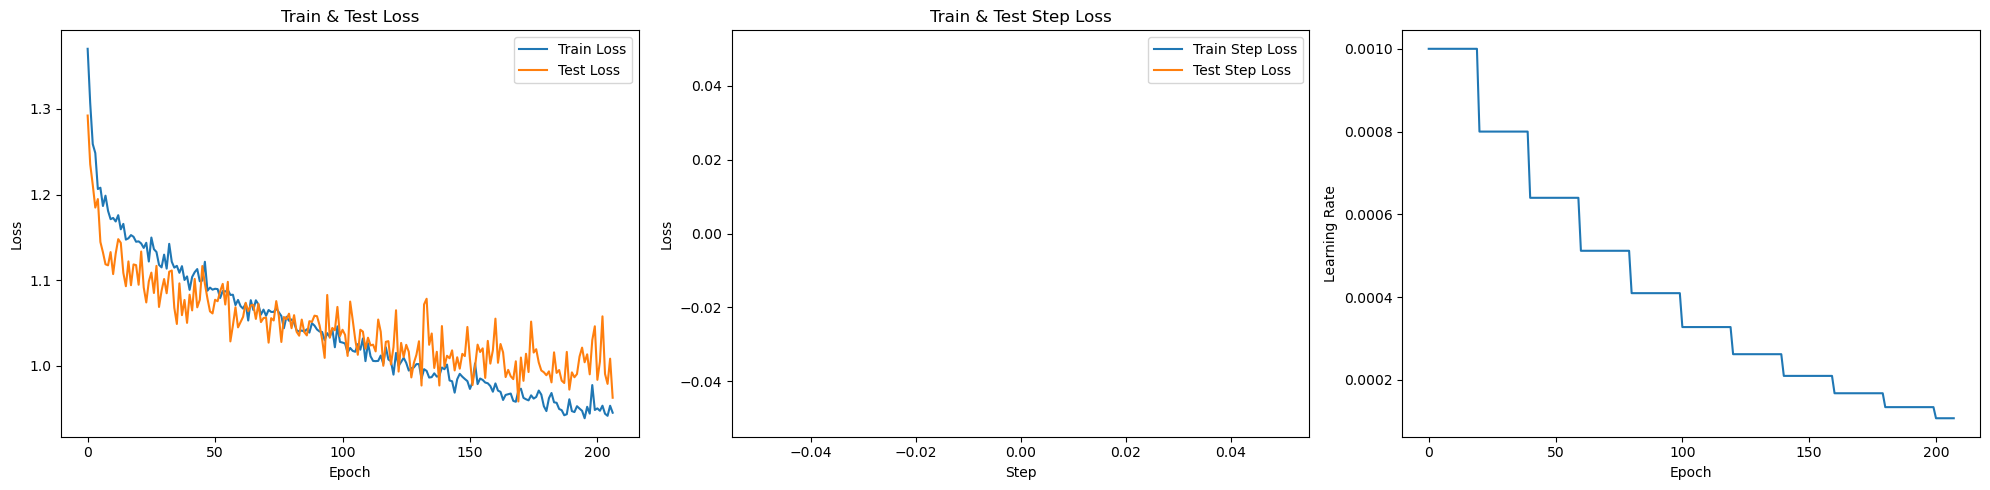

In [12]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_step_losses, label="Train Step Loss")
plt.plot(test_step_losses, label="Test Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train & Test Step Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.savefig("plot.png")

plt.tight_layout()
plt.show()